In [1135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, quad_vec
import lhapdf
import h5py
from scipy.special import beta, digamma, gamma, loggamma, polygamma

In [189]:
# Running coupling

Mc = 1.3
Mb = 4.2
Mz = 91.7

CA = 3.
CF = 4./3.
TR = 1./2.

Nf = 3

beta0 = 11/3*CA-2/3*Nf

b0_q = 2./(11.-2./3.*3);
b0_c = 2./(11.-2./3.*4);
b0_b = 2./(11.-2./3.*5);
alphas_Mz_bar = 0.118 / 2. / np.pi;
Lambda2_b = Mz**2/np.exp(b0_b/alphas_Mz_bar);
a5_Mb_bar = b0_b/np.log((2*Mb)**2/Lambda2_b);
Lambda2_c = (2*Mb)**2/np.exp(b0_c/a5_Mb_bar);
a4_Mc_bar = b0_c/np.log((2*Mc)**2/Lambda2_c);
Lambda2_q = (2*Mc)**2/np.exp(b0_q/a4_Mc_bar);
NPscale2 = Lambda2_q * 4.0;

tc = b0_q*np.log(np.log(4*Mc*Mc/Lambda2_q));
tb = b0_c*np.log(np.log(4*Mb*Mb/Lambda2_c))\
   - b0_c*np.log(np.log(4*Mc*Mc/Lambda2_c))\
   + b0_q*np.log(np.log(4*Mc*Mc/Lambda2_q));

In [190]:
# PDF and FF
PDFp = lhapdf.mkPDF("NNPDF31_nlo_as_0118")
PDFd = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A2_Z1/0")
PDFHe = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A4_Z2/0")
PDFNe = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A16_Z8/0")
PDFKr = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A56_Z26/0")
PDFXe = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A131_Z54/0")
PDFPb = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A208_Z82/0")
@np.vectorize
def xPp(pid, x, Q2):
    return PDFp.xfxQ2(pid, x, Q2)
@np.vectorize
def xPd(pid, x, Q2):
    return PDFd.xfxQ2(pid, x, Q2)
@np.vectorize
def xPHe(pid, x, Q2):
    return PDFHe.xfxQ2(pid, x, Q2)
@np.vectorize
def xPNe(pid, x, Q2):
    return PDFNe.xfxQ2(pid, x, Q2)
@np.vectorize
def xPKr(pid, x, Q2):
    return PDFKr.xfxQ2(pid, x, Q2)
@np.vectorize
def xPXe(pid, x, Q2):
    return PDFXe.xfxQ2(pid, x, Q2)
@np.vectorize
def xPPb(pid, x, Q2):
    return PDFPb.xfxQ2(pid, x, Q2)

LHAPDF 6.4.0 loading /home/weiyaoke/.local/share/LHAPDF/NNPDF31_nlo_as_0118/NNPDF31_nlo_as_0118_0000.dat
NNPDF31_nlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303400
LHAPDF 6.4.0 loading /home/weiyaoke/.local/share/LHAPDF/nNNPDF30_nlo_as_0118_A2_Z1/nNNPDF30_nlo_as_0118_A2_Z1_0000.dat
nNNPDF30_nlo_as_0118_A2_Z1 PDF set, member #0, version 1; LHAPDF ID = 30020300
LHAPDF 6.4.0 loading /home/weiyaoke/.local/share/LHAPDF/nNNPDF30_nlo_as_0118_A4_Z2/nNNPDF30_nlo_as_0118_A4_Z2_0000.dat
nNNPDF30_nlo_as_0118_A4_Z2 PDF set, member #0, version 1; LHAPDF ID = 30020600
LHAPDF 6.4.0 loading /home/weiyaoke/.local/share/LHAPDF/nNNPDF30_nlo_as_0118_A16_Z8/nNNPDF30_nlo_as_0118_A16_Z8_0000.dat
nNNPDF30_nlo_as_0118_A16_Z8 PDF set, member #0, version 1; LHAPDF ID = 30022100
LHAPDF 6.4.0 loading /home/weiyaoke/.local/share/LHAPDF/nNNPDF30_nlo_as_0118_A56_Z26/nNNPDF30_nlo_as_0118_A56_Z26_0000.dat
nNNPDF30_nlo_as_0118_A56_Z26 PDF set, member #0, version 1; LHAPDF ID = 30023300
LHAPDF 6.4.0 loading /ho

In [4]:
# Runge-Kuta-4 for ODE systems
def RK4(t, y, dydt, dt):
    k1 = dydt(t, y)
    k2 = dydt(t+dt/2., y+dt/2.*k1)
    k3 = dydt(t+dt/2., y+dt/2.*k2)
    k4 = dydt(t+dt, y+dt*k3)
    dy = dt/6. * (k1 + k2*2. + k3*2. + k4)
    return y+dy

# Runge-Kuta-1
def RK1(t, y, dydt, dt):
    k1 = dydt(t, y)
    return y+k1*dt

In [5]:
# Vacuum DGLAP kernels

# Pqq
@np.vectorize
def Rqq(x, kt2):
    return CF*(1+x**2)
@np.vectorize
def Dqq(Q2):
    return CF*3./2.
# Pgg
@np.vectorize
def Rgg(x, kt2):
    return 2*CA * x
@np.vectorize
def Agg(x, kt2):
    return 2*CA * ( (1-x)/x + x*(1-x) )
@np.vectorize
def Dgg(Q2):
    return 2*CA * 11./12.
@np.vectorize
def Dgq(Q2):
    return - 1./3.
# Pqg
@np.vectorize
def Pqg(x, kt2):
    return CF * (1+(1-x)**2)/x
# Pqg
@np.vectorize
def Pgq(x, kt2):
    return TR*(x**2+(1-x)**2) 


In [6]:
# scheme-1 R(x)/[(1-x)]_+
# Flavor non singlet: q - qbar
def dF_NS_dt(t, zD):
    #print(zD[0].sum()*dlnx)
    Q2 = Lambda2_q * np.exp(np.exp(t/b0_q))
    kt2 = np.ones_like(xgrid)*Q2
    
    Ni, N = zD.shape
    dydt = np.zeros_like(zD)
    Rgrids = Rqq(xgrid, kt2)
    zover1mz = xgrid/(1-xgrid)
    for k in range(Ni):
        for i in range(N):

            x = xgrid[i]
            S1 = 0.0
            for j in range(i,N):
                S1 += (zD[k,N-1-j+i]*Rgrids[j] - zD[k,i]*Rgrids[N-1]) * zover1mz[j] * dlnx
            dydt[k,i] += S1

            S2 = 0.0
            for j in range(i):
                S2 +=  zover1mz[j] * dlnx
            dydt[k,i] -= S2 * zD[k,i]*Rgrids[N-1]
            dydt[k,i] += Dqq(Q2)*zD[k,i]
    return dydt

# Coupled flavor singlet
def dF_S_dt(t, zD):
    Q2 = Lambda2_q * np.exp(np.exp(t/b0_q))
    kt2 = np.ones_like(xgrid)*Q2
    zG = zD[0]
    zQs = zD[1:]
    Nf = zQs.shape[0]
    N = zG.size
    dydt = np.zeros_like(zD)
    zover1mz = xgrid/(1-xgrid)
    
    # Gluon part
    Rgrids = Rgg(xgrid, kt2)
    Agrids = Agg(xgrid, kt2)
    Pgrids = Pqg(xgrid, kt2)
    for i in range(N):
        x = xgrid[i]
        # From g->g
        S1 = 0.0
        for j in range(i,N-1):
            S1 += (zG[N-1-j+i]*Rgrids[j] - zG[i]*Rgrids[N-1]) * zover1mz[j]
        dydt[0,i] += S1 * dlnx
        S2 = 0.0
        for j in range(i):
            S2 +=  zover1mz[j]
        dydt[0,i] -= S2 * dlnx * zG[i]*Rgrids[N-1]
        for j in range(i,N):
            dydt[0,i] += zG[N-1-j+i]*Agrids[j]*xgrid[j] * dlnx
        dydt[0,i] += (Dgg(Q2)+Nf*Dgq(Q2))*zG[i]
        # From q -> q + g
        for j in range(i,N):
            dydt[0,i] += np.sum([zQs[iq][N-1-j+i] for iq in range(Nf)])*Pgrids[j]*xgrid[j] * dlnx
          
    # q+qbar part
    Rgrids = Rqq(xgrid, kt2)
    Pgrids = Pgq(xgrid, kt2)
    for iq in range(Nf):
        for i in range(N):        
            S1 = 0.0
            for j in range(i,N-1):
                S1 += (zQs[iq,N-1-j+i]*Rgrids[j] - zQs[iq,i]*Rgrids[N-1]) * zover1mz[j]
            dydt[1+iq,i] += S1 * dlnx
            S2 = 0.0
            for j in range(i):
                S2 +=  zover1mz[j]
            dydt[1+iq,i] -= S2 * dlnx * zQs[iq,i]*Rgrids[N-1]
            dydt[1+iq,i] += Dqq(Q2)*zQs[iq,i]
            # From g->qqbar
            for j in range(i,N):
                dydt[1+iq,i] += 2*zG[N-1-j+i]*Pgrids[j]*xgrid[j] * dlnx
    return dydt

In [1220]:
# Vacuum DGLAP kernel in the Melin space
# f(N) = int_0^1 dz z^{N-1} f(z)

def Mqq(N):
    return CF * (3./2. - (1+2*N)/(N*(N+1)) - 2.*np.euler_gamma - 2.*digamma(N) ) 

def Mqg(N):
    return CF * (N**2 + N + 2) / (N**3 - N) 

def Mgg(N):
    return CA * ( 2./(N*(N-1)) + 2/((N+1)*(N+2)) - 2.*np.euler_gamma - 2.*digamma(N+1) )\
         + beta0/2.

def Mgq(N):
    return TR*(N**2+N+2)/(N*(N+1)*(N+2))

def alpha(mu2):
    return 4*np.pi/beta0/np.log(mu2/Lambda2_q)

def Mevo(N, dt):
    a = Mqq(N); b = Mqg(N)
    c = 2*Nf*Mgq(N); d = Mgg(N)

    Delta = np.sqrt( (a-d)**2 + 4.*b*c)
    S1 = np.exp(dt * ( a + d - Delta ) / 2. )
    S2 = np.exp(dt * ( a + d + Delta ) / 2. )
    A = (a - d - Delta)/2.
    B = (a - d + Delta)/2.
    
    E1 =      np.array([[A, b],
                        [c,-B]]) * S1
    E2 =      np.array([[B, b],
                        [c,-A]]) * S2
    return (E2 - E1)/Delta


def IC(N, Q20): # z^b(1-z)^a
    abar = alpha(Q20)/2/np.pi
    gE = np.euler_gamma
    trigammaN = (digamma(N+.01)-digamma(N-.01))/.02
    trigammaNm1 = (digamma(N-1+.01)-digamma(N-1-.01))/.02
    # The leading order part
    S0 = 1 #np.exp(loggamma(b+N)-loggamma(a+b+N+1)-loggamma(b+1)+loggamma(a+b+2))


    
    # NLO quark
    A = 1/(N**2*(1+N)**2) + (3+gE+gE*N*(2+gE+gE*N))/N/(1+N) + np.pi**2/6.\
      + digamma(N)*(2*gE+1/N+1/(1+N)+digamma(N)) - trigammaN
    dJq = CF*np.pi**2/12. + CF*(13./2.-2*np.pi**2/3.)
    B = (2+3*N)/(N**2*(1+N)**2) - (gE+digamma(N))*(N**2+N+2)/((N-1)*N*(N+1))
    S1q = - abar * (2*CF*A + CF/N - dJq + 2*CF*B)
    
    # NLO gluon
    A = 1./(12*(N-1)*N**2*(N+1)**2*(N+2)**2) * (
-96
-72*N-96*gE*N
+264*N**2-168*gE*N**2-24*gE**2*N**2
+396*N**3-12*gE*N**3-48*gE**2*N**3
+240*N**4+144*gE*N**4-6*gE**2*N**4
+60*N**5+108*gE*N**5+42*gE**2*N**5
+24*gE*N**6+30*gE**2*N**6
+6*gE**2*N**7
        
-4*np.pi**2*N**2
-8*np.pi**2*N**3
-np.pi**2*N**4
+7*np.pi**2*N**5
+5*np.pi**2*N**6
+np.pi**2*N**7

+12*N*(-2-N+2*N**2+N**3)*(4+(5+2*gE)*N+(2+3*gE)*N**2+gE*N**3)*digamma(N-1)

+6*(N-1)*N**2*(2+3*N+N**2)**2*digamma(N-1)**2
        
-6*(N-1)*N**2*(2+3*N+N**2)**2*trigammaNm1
        
)
    dJg = CA*np.pi**2/12. + CA*(67/9.-2*np.pi**2/3.) - TR*Nf*23./9.
    B = 1./((1+N)**2*(2+N)**2) * (4+N-N**2 - (1+N)*(2+N)*(2+N+N**2)/N*(gE+digamma(N+1)))
    S1g = - abar * (4*CA*A - dJg + 4*Nf*TR*B*0)
    return S0+S1q, S0+S1g



def RG_MJ(N, dt, Q20):
    Matrix = Mevo(N, dt)
    Jq0, Jg0 = IC(N, Q20)
    Jq1 = Matrix[0,0]*Jq0 + Matrix[0,1]*Jg0
    Jg1 = Matrix[1,0]*Jq0 + Matrix[1,1]*Jg0
    return np.array([Jq1, Jg1])

In [1221]:
@np.vectorize
def RG_J(zz, Q2max, Q2min):
    ReN = 4
    phi = 3./4.*np.pi
    lnz = np.log(zz)
    dt = -2/beta0*np.log(alpha(Q2max)/alpha(Q2min))
    
    Ephi = np.exp(1j*phi)
    Ephi_c = np.exp(-1j*phi)

    def df(ln1px):
        x = np.exp(ln1px) - 1.
        
        # upper contour
        N = ReN + x*Ephi
        MJq, MJg = RG_MJ(N, dt, Q2min)
        IM_up = np.exp( - N*lnz + 1j*phi - 1j*np.pi/2)
        QA = (MJq * IM_up).real
        GA = (MJg * IM_up).real

        # the negative of the lower contour
        N = ReN + x*Ephi_c
        MJq, MJg = RG_MJ(N, dt, Q2min)
        IM_down = np.exp( - N*lnz - 1j*phi - 1j*np.pi/2)
        QB = (MJq * IM_down).real
        GB = (MJg * IM_down).real
        return np.array([ QA-QB, GA-GB ]) * (1+x) # with Jacobian

    
    Jq, Jg = quad_vec(df, 0, np.log(1-30/lnz), epsrel=.05)[0]
    return Jq/2/np.pi , Jg/2/np.pi 

In [1222]:
u = np.linspace(np.log(.01),-np.log(.001),51)
z = 1/(1+np.exp(-u))

In [1223]:
pT = 250
Q2max = pT**2


/tmp/ipykernel_535707/308305935.py:20: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


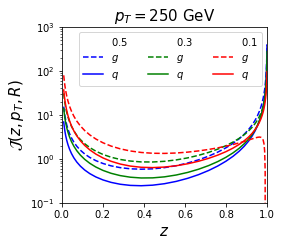

In [1228]:
plt.figure(figsize=(4,3.5))

for R,c in zip([.5,.3, .1],'bgrck'):
    Q2min = (pT*R)**2
    Jq, Jg = RG_J(z, Q2max, Q2min)
    plt.plot([],[],color='none',label='${}$'.format(R))
    plt.plot(z, Jg, '--', color=c, label=r'$g$')
    plt.plot(z, Jq, '-', color=c, label=r'$q$')

plt.xlim(.0,1)
#plt.ylim(-10,10)
plt.ylim(1e-1,1e3)
plt.legend(ncol=3)
plt.plot(z,z*0,'k--',lw=.5)
#plt.semilogx()
plt.semilogy()
plt.xlabel("$z$", fontsize=15)
plt.ylabel("$\mathcal{J}(z, p_T, R)$", fontsize=15)
plt.title(r"$p_T=250$ GeV", fontsize=15)
plt.tight_layout(True)

plt.savefig("JetFunctions-R.png", dpi=300)

In [1095]:
# Vacuum Grid
Nx = 100
lnxgrid = np.linspace(np.log(0.01),np.log(.9999),Nx)
xgrid = np.exp(lnxgrid)
dlnx = lnxgrid[1]-lnxgrid[0]

In [1096]:
# Jet function initial conditions 
JF0 = []
# use fixed order results as IC: delta(1-z) + alpha_s*(L+...) with mu0 set to kill L.
for i in range(Nf+1): # g,ddbar, uubar, ssbar
    JF0.append(xgrid**10*(1-xgrid))
JF0 = np.array(JF0)
pT = 100
Q2max = pT**2
R = 0.2
Q2min = (pT*R)**2

In [1097]:
t0 = b0_q*np.log(np.log(Q2min/Lambda2_q))
t1 = b0_q*np.log(np.log(Q2max/Lambda2_q))
Nt = 10
dt = (t1-t0)/Nt
tarray = np.linspace(t0, t1, Nt)
Q2array =  Lambda2_q*np.exp(np.exp(tarray/b0_q))

In [1098]:
# Evolution
JF = [JF0]
for t in tarray:
    print(t)
    JF.append( RK4(t, JF[-1][:(Nf+1)], dF_S_dt, dt) )
JF = np.array(JF)

0.5042085442283841
0.5113038215931839
0.5183990989579836
0.5254943763227835
0.5325896536875833
0.539684931052383
0.5467802084171828
0.5538754857819825
0.5609707631467824
0.5680660405115822


In [ ]:
# Interpolate the solution at the final scale
JF1 = []
for iF in JF[-1]:
    JF1.append(interp1d(lnxgrid, iF, fill_value=0, kind='cubic', bounds_error=False))


In [ ]:
plt.subplot(1,2,1)

X = np.linspace(1e-3,1-1e-3,1000)

for iF1, iF0, c in zip(JF1, JF0,'rgbcky'):
    plt.plot(xgrid, iF0, '--', color=c)
    plt.plot(X, iF1(np.log(X)), '-', color=c)

In [ ]:
#0.375*8

In [ ]:
#Lp = np.linspace(0,1,13)
#print((Lp[1:]+Lp[:-1])/2.)
Anumber

In [ ]:
def qhat(E):
    def df(q2):
        return 4*np.pi/9/np.log(np.min([La2*np.e,q2])/La2) * CA * q2/(q2+m2)**2 * rho * 5.076
    return quad(df, 0, E*m2**.5/2)[0]
qhat(10)

0.0195*0.1**(-0.174)*(1-0.1)**(-2.79)*(np.log(2.0/1.0))**0.254

In [ ]:
# Medium part
Lp = 0.9
rho = 0.17/5.076**3 
Lmax = 1.16*Anumber**(1./3.)*2*5.076 

L = Lmax * Lp

La2 = Lambda2_q*1.
m2 = 0.12
E = Ee*yavg/Shift
print(E)
Tmax = np.pi/9*rho*L**2/2/E*4*np.pi/9*1/np.log(m2/La2)*10*E/L/m2
Nz = 200
y = np.linspace(np.log(.1), np.log(1), Nz)
dy = y[1]-y[0]
z = np.exp(y)
print(ag)
dtau = dy/ag

In [ ]:
# Compute matching coefficient


@np.vectorize
def p(x, it):
    if it==0:
        return (1+x**4+(1-x)**4) * (CA+CA*x**2+(1-x)**2*CA)
    else: 
        return (1+x**2) * (CA+CA*x**2+(1-x)**2*(2*CF-CA))
@np.vectorize
def SubtractInt(z, it, FF):
    B = FF(z)/z
    dfdz1 = (FF(z+.005)-FF(z-.005))/.01
    P1 = p(1, it)
    def G1_2(x):
        A = x/z*FF(z/x) if x>z else 0.
        res =  p(x, it)*(A-B) - (x-1)*P1*(B-dfdz1)
        return res

    def G1_1(x):
        A = x/z*FF(z/x) if x>z else 0.
        res =  p(x, it)*A-P1*B
        return res
    
    def G0_1(x):
        A = x/z*FF(z/x) if x>z else 0.
        res =  p(x, it)*A-(p(x, it)-p(0, it))*B
        return res
    
    
    return quad(lambda x: G1_2(x)/(1-x)**2,.05,.95,epsrel=.05)[0] \
         + quad(lambda x: G1_1(x)/(1-x),.05,.95,epsrel=.05)[0] \
         + quad(lambda x: G0_1(x)/x,.05,.95,epsrel=.05)[0]



ZFO = np.linspace(.7,.999,200)
Fmed_fixed_order = []
Amu2 = (4*np.pi/9)**2/np.log(np.max([5*ZFO*E/L/La2,ZFO**0*m2/La2],axis=0))**2 * rho*L**2/8/E
for it, match in zip([0,1,2,3,4,5], [14*CA]+[(4*CA-CF)]*5 ):
    print(it)
    iF1 = interp1d(xgrid, FQA[-1][it], fill_value=0, kind='cubic', bounds_error=False)
    YFO = match*Amu2 *  iF1(ZFO)/ZFO + SubtractInt(ZFO, it, iF1)*Amu2
    Fmed_fixed_order.append(interp1d(ZFO, YFO, fill_value=0., kind='cubic', bounds_error=False))

In [ ]:
# RG part, compare two medthods: RK4 or flux limitter

#Fmed0 = [ np.array([F1[iv](y) for iv in range(6)]) ] # RK4
Fmed = [ np.array([F1[iv](y) for iv in range(6)]) ] # flux limiter

Ts = np.arange(int(Tmax/dtau))*dtau
for it in Ts:
    
    #iF = np.concatenate([RK4(it, Fmed0[-1][:Nf+1], Rate_S, dtau),
    #                     RK4(it, Fmed0[-1][Nf+1:], Rate_NS, dtau) ], axis=0)
    #Fmed0.append(iF)
    
    iF = np.concatenate([Fmed[-1][:Nf+1] + DeltaY_S(dtau, it, dy, Fmed[-1][:Nf+1]),
                         Fmed[-1][Nf+1:] + DeltaY_NS(dtau, it, dy, Fmed[-1][Nf+1:])], axis=0)
    Fmed.append(iF)

Fmed = np.array(Fmed)
F2 = []
for i in range(6):
    F2.append(interp2d(y, Ts, Fmed[1:,i]))
    
#Fmed0 = np.array(Fmed0)
#F2s = []
#for i in range(6):
#    F2s.append(interp2d(y, Ts, Fmed0[1:,i]))

In [ ]:
# Check the RG vs RG+fix



zF2RG = []
zF2Full = []
Zgrid = np.linspace(.1,.9999,2000)
Tauy = -np.pi/9*rho*L**2/2/E*4*np.pi/9*(1/np.log(np.max([5*Zgrid*E/L/La2,m2/La2*Zgrid**0],axis=0))-1/np.log(m2/La2))
Ty = Tauy/Zgrid

for Ffix, iF, iF0, iFv, c in zip(Fmed_fixed_order, F2, FQA[0], F1,'rgbcky'):
    RG = np.array([iF(iy, iTy)[0] for iy, iTy in zip(np.log(Zgrid), Ty)])
    zF2RG.append(RG)
    zF2Full.append(RG+Ffix(Zgrid))
    if c=='k':
        plt.plot(xgrid, iF0, '-', color=c, label=r'$(Q,\xi z E/L)$' if c=='g' else '')
        plt.plot(Zgrid, iFv(np.log(Zgrid)), '--', color=c, label=r'$(Q_0,\xi z E/L)$' if c=='g' else '')
        plt.plot(Zgrid, RG, '-.', color=c, label=r'$(Q_0, \mu_D^2)$' if c=='g' else '')
        plt.plot(Zgrid, Ffix(Zgrid), ':', color=c, label=r'FO' if c=='g' else '')
plt.legend(fontsize=15)

In [ ]:
# interpolate the final spectra
zFmedFull = {
21: interp1d(Zgrid,zF2Full[0],fill_value=0., bounds_error=False, kind='cubic'),
1: interp1d(Zgrid,(zF2Full[1]+zF2Full[1+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
-1: interp1d(Zgrid,(zF2Full[1]-zF2Full[1+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
2: interp1d(Zgrid,(zF2Full[2]+zF2Full[2+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
-2: interp1d(Zgrid,(zF2Full[2]-zF2Full[2+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
3: interp1d(Zgrid, zF2Full[3]/2.,fill_value=0., bounds_error=False, kind='cubic'),
-3: interp1d(Zgrid, zF2Full[3]/2.,fill_value=0., bounds_error=False, kind='cubic'),
}

zFmedRG = {
21: interp1d(Zgrid,zF2RG[0],fill_value=0., bounds_error=False, kind='cubic'),
1: interp1d(Zgrid,(zF2RG[1]+zF2RG[1+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
-1: interp1d(Zgrid,(zF2RG[1]-zF2RG[1+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
2: interp1d(Zgrid,(zF2RG[2]+zF2RG[2+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
-2: interp1d(Zgrid,(zF2RG[2]-zF2RG[2+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
3: interp1d(Zgrid, zF2RG[3]/2.,fill_value=0., bounds_error=False, kind='cubic'),
-3: interp1d(Zgrid, zF2RG[3]/2.,fill_value=0., bounds_error=False, kind='cubic'),
}

zFvac = {
21: interp1d(xgrid,FQd[-1][0],fill_value=0., bounds_error=False, kind='cubic'),
1: interp1d(xgrid,(FQd[-1][1]+FQd[-1][1+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
-1: interp1d(xgrid,(FQd[-1][1]-FQd[-1][1+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
2: interp1d(xgrid,(FQd[-1][2]+FQd[-1][2+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
-2: interp1d(xgrid,(FQd[-1][2]-FQd[-1][2+Nf])/2.,fill_value=0., bounds_error=False, kind='cubic'),
3: interp1d(xgrid, FQd[-1][3]/2.,fill_value=0., bounds_error=False, kind='cubic'),
-3: interp1d(xgrid, FQd[-1][3]/2.,fill_value=0., bounds_error=False, kind='cubic'),
}


@np.vectorize
def F2pi(zh, Spectra):
    def df(lnx):
        x = np.exp(lnx)
        res = 0.
        for pid in [21,1,2,3,-1,-2,-3]:
            res += Spectra[pid](x) * FFpi.xfxQ2(pid,zh/x,Q20) 
        return res
    return quad(df, np.log(zh), np.log(1), epsrel=.04)[0]
    
zh = np.linspace(.05, .99, 41)
zdNdz_pi_medFull = F2pi(zh, zFmedFull)
zdNdz_pi_medRG = F2pi(zh, zFmedRG)
zdNdz_pi_vac = F2pi(zh, zFvac)



In [ ]:

with open("res-{}-Qsq20-x0d5-Lp{}.dat".format(Nucl,Lp),'w') as f:
    for i1, i2, i3, i4, i5 in zip(zh, zdNdz_pi_medRG, zdNdz_pi_vac, zdNdz_pi_medFull, zdNdz_pi_vac):
        f.write("{:1.4f}\t{:1.4e}\t{:1.4e}\t{:1.4e}\t{:1.4e}\n".format(i1,i2,i3,i4,i5))


In [ ]:

plt.figure(figsize=(4,3.))
def plotE(GG,c):
    z,zl,zh,RA,stat,_,sys,_ = np.loadtxt("../TMDPDF/HERMES/e{}-pi+.dat".format(GG), skiprows=12,delimiter=',').T
    plt.errorbar(z,RA,xerr=[z-zl, zh-z], yerr=stat, fmt='D',color=c, label=r'HERMES, $e{{\rm{}}}\rightarrow\pi^+$'.format(GG))

Lps = np.array([0.1, 0.3, 0.5, 0.7, 0.9])

plotE('Xe','b')
ZH, A0, D0, A1, D1 = np.average([np.loadtxt("res-Xe-Lp{}.dat".format(sl)) for sl in Lps],
                        weights=1-Lps**2, axis=0).T
plt.plot(ZH/Shift, A1/D1, 'b--', label='RG + Fixed order')
plt.plot(ZH/Shift, A0/D0, 'b-', label='RG only')

plotE('Ne','r')
ZH, A0, D0, A1, D1 = np.average([np.loadtxt("res-Ne-Lp{}.dat".format(sl)) for sl in Lps],
                        weights=1-Lps**2, axis=0).T
plt.plot(ZH/Shift, A1/D1, 'r--')
plt.plot(ZH/Shift, A0/D0, 'r-')

Ehermes = 12
L1 = 1.16*131**0.33333333*0.75*5.076
T1 = -np.pi/9*rho*L1**2/2/Ehermes*4*np.pi/9*(1/np.log(np.max([5*E/L1/La2,m2/La2],axis=0))-1/np.log(m2/La2))
zc = 1-4*CF*CA*T1*1.5
plt.fill_between([zc,1.04],[0,0],[.6,.6], alpha=.4, color='b')

L1 = 1.16*20**0.33333333*0.75*5.076
T1 = -np.pi/9*rho*L1**2/2/Ehermes*4*np.pi/9*(1/np.log(np.max([5*E/L1/La2,m2/La2],axis=0))-1/np.log(m2/La2))
zc = 1-4*CF*CA*T1*1.5
plt.fill_between([zc,1.04],[0,0],[1,1], alpha=.6, facecolor='none', edgecolor='r', hatch='////')

plt.legend(fontsize=12, framealpha=0)
plt.xlim(0,1.0)
plt.ylim(.0,1.05)
plt.xlabel("$z_h$", fontsize=15)
plt.ylabel("$R_{A}$", fontsize=15)
#plt.title("Not using exact the same kinematic cuts", fontsize=15)
plt.tight_layout(True)
plt.savefig("RA-RG-fixed-order.png",dpi=300)

In [ ]:

plt.figure(figsize=(4,3.))
Lps = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
for x0, lx0, r, ss, color in zip([0.1, 0.3, 0.5], 
                                 ["0d1", "0d3", "0d5"], 
                                 [-5,-15,-20], 
                                 [.82,.43,.045], 
                                 'rgb'):
    nu = Q2max/2/0.938/x0
    label=r"$x={},~\nu={:1.0f}{{\rm~GeV}},~y={:1.3f}$".format(x0, nu, nu/1000) 

    ZH, A0, D0, A1, D1 = np.average([np.loadtxt("res-Pb-Qsq20-x{}-Lp{}.dat".format(lx0,sl)) for sl in Lps],
                        weights=1-Lps**2, axis=0).T
    plt.plot(ZH/Shift, A1/D1, '-', color=color, alpha=1)
    plt.plot(ZH/Shift, A0/D0, '--', color=color, alpha=1)
    plt.annotate(label, xy=(.1,ss), rotation=r)
    
    L1 = 1.2*208**0.33333333*0.75*5.076
    T1 = -np.pi/9*rho*L1**2/2/nu*4*np.pi/9*(1/np.log(np.max([5*E/L1/La2,m2/La2],axis=0))-1/np.log(m2/La2))
    zc = 1-4*CF*CA*T1*1.
    plt.fill_between([zc,1.04],[0,0],[interp1d(ZH/Shift, A1/D1)(zc)]*2, alpha=.6, 
                     facecolor='none', edgecolor=color, hatch='////')


plt.annotate(r"$e$+Pb$\rightarrow\pi^+$"+"\n"+r"$Q^2=20$ GeV$^2$", xy=(.02,.04), fontsize=12)
plt.legend(fontsize=12, framealpha=0)

plt.xlim(0,1.0)
plt.ylim(.0,1.)
plt.xlabel("$z_h$", fontsize=15)
plt.ylabel("$R_{A}$", fontsize=15)

plt.tight_layout(True)
plt.savefig("RA-EIC.png",dpi=300)

In [ ]:

fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(4,4.5))
def plotE(GG,c,ax,mfc='none'):
    z,zl,zh,RA,stat,_,sys,_ = np.loadtxt("../TMDPDF/HERMES/e{}-pi+.dat".format(GG), skiprows=12,delimiter=',').T
    ax.errorbar(z,RA,xerr=[z-zl, zh-z], yerr=stat, mfc=mfc, fmt='D', lw=1.2,
                color=c, label=r'HERMES, $e{{\rm{}}}\rightarrow\pi^+$'.format(GG))

cr, cg, cb = plt.cm.Reds(.7), plt.cm.Greens(.7), plt.cm.Blues(.7)
    
ax = axes[0]
plotE('Xe',cb, ax)


ZH, A0, D0, A1, D1 = np.average([np.loadtxt("res-Xe-Lp{}.dat".format(sl)) for sl in Lps],
                        weights=1-Lps**2, axis=0).T
ax.plot(ZH/Shift, A1/D1, '-', color=cb, label='RG + Fixed order', lw=2)
ax.plot(ZH/Shift, A0/D0, '--', color=cb, label='RG only', lw=2)

plotE('Ne',cr, ax,cr)
ZH, A0, D0, A1, D1 = np.average([np.loadtxt("res-Ne-Lp{}.dat".format(sl)) for sl in Lps],
                        weights=1-Lps**2, axis=0).T
ax.plot(ZH/Shift, A1/D1, '-', color=cr, label='', lw=2)
ax.plot(ZH/Shift, A0/D0, '--', color=cr, label='', lw=2)


Ehermes = 12
L1 = 1.2*131**0.33333333*0.75*5.076
T1 = -np.pi/9*rho*L1**2/2/Ehermes*4*np.pi/9*(1/np.log(np.max([5*E/L1/La2,m2/La2],axis=0))-1/np.log(m2/La2))
zc = 1-4*CF*CA*T1
ax.fill_between([zc,1.04],[0,0],[.6,.6], alpha=.6, facecolor='none',
                edgecolor=cb, hatch='////')

L1 = 1.2*20**0.33333333*0.75*5.076
T1 = -np.pi/9*rho*L1**2/2/Ehermes*4*np.pi/9*(1/np.log(np.max([5*E/L1/La2,m2/La2],axis=0))-1/np.log(m2/La2))
zc = 1-4*CF*CA*T1
ax.fill_between([zc,1.04],[0,0],[1,1], alpha=.6, facecolor='none',
                edgecolor=cr, hatch='////')

ax.legend(loc=(.01,.01),fontsize=12, framealpha=0)
ax.set_xlim(0,1)
ax.set_ylim(.0,1.05)
ax.set_xticklabels([])
#ax.set_xlabel("$z_h$", fontsize=15)
ax.set_ylabel("$R_{A}$", fontsize=15)
#


ax = axes[1]
for x0, lx0, r, ss, color in zip([0.1, 0.3, 0.5], 
                                 ["0d1", "0d3", "0d5"], 
                                 [-4,-8,-10], 
                                 [.8,.45,.1], 
                                 [cr,cg,cb]):
    nu = 20.0/2/0.938/x0
    label=r"$x_B={},~\nu={:1.0f}{{\rm~GeV}}$".format(x0, nu, nu/1000) 
    ZH, A0, D0, A1, D1 = np.average([np.loadtxt("res-Pb-Qsq20-x{}-Lp{}.dat".format(lx0,sl)) for sl in Lps],
                        weights=1-Lps**2, axis=0).T
    plt.plot(ZH/Shift, A1/D1, '-', color=color, alpha=1)
    plt.plot(ZH/Shift, A0/D0, '--', color=color, alpha=1)
    ax.annotate(label, xy=(.25,ss), rotation=r)
    
    L1 = 1.2*208**0.33333333*0.75*5.076
    T1 = -np.pi/9*rho*L1**2/2/nu*4*np.pi/9*(1/np.log(np.max([5*E/L1/La2,m2/La2],axis=0))-1/np.log(m2/La2))
    zc = 1-4*CF*CA*T1*1.5
    ax.fill_between([zc,1.04],[0,0],[interp1d(ZH/Shift, Y1)(zc)]*2, alpha=.6, 
                     facecolor='none', edgecolor=color, hatch='////')


ax.annotate(r"$e(10~\mathrm{GeV})$+Pb$(100~\mathrm{GeV})\rightarrow\pi^+$",
            xy=(.02,1.06), fontsize=12)
ax.annotate(r"$Q^2=20$ GeV$^2$",
            xy=(.02,.035), fontsize=12)
ax.legend(fontsize=12, framealpha=0)

ax.set_xlim(0,1.0)
ax.set_ylim(.0,1.199)
ax.set_xlabel("$z_h$", fontsize=15)
ax.set_ylabel("$R_{A}$", fontsize=15)




plt.tight_layout(True)

plt.subplots_adjust(hspace=0)


plt.savefig("RA-RG-fixed-order.png",dpi=400)